This notebook contains:

1) Model V2, trained on training data and tested on sub-part of training data as validation data. The test data was separated before (see for this code f.e. model v1)
2) Saving and reloading the model (so it does not need to be trained again when to be used for GUI)
3) a gradio GUI with a local (or public) link to predict on images with the model

Have fun with using it!

In [5]:
# Importing necessary libraries
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.layers.experimental import preprocessing
import numpy as np
import os
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold

In [7]:
# Define the directory path containing the images
data_directory = "/Users/linn/Desktop/original_dataset/train_data"
batch_size = 7
image_size = (50,50)
epoch_size = 200
fold_size = 3

In [4]:
# Create the KFold object
kfold = KFold(n_splits=fold_size, shuffle=True, random_state=42)

In [5]:
# Initialize lists to store the fold results
fold_train_loss = []
fold_train_accuracy = []
fold_val_loss = []
fold_val_accuracy = []

In [6]:
# Perform k-fold cross-validation
fold = 1
for train_index, val_index in kfold.split(os.listdir(data_directory)):
    print(f"Fold {fold}:")

    # Load and preprocess the data for training set
    train_data = tf.keras.preprocessing.image_dataset_from_directory(
        data_directory,
        batch_size=batch_size,
        image_size=image_size,
        shuffle=True,
        seed=42,
        validation_split=0.2,
        subset="training"
    )

    # Load and preprocess the data for validation set
    val_data = tf.keras.preprocessing.image_dataset_from_directory(
        data_directory,
        batch_size=batch_size,
        image_size=image_size,
        shuffle=True,
        seed=42,
        validation_split=0.2,
        subset="validation"
    )

    # Define data augmentation
    data_augmentation = tf.keras.Sequential([
      preprocessing.Rescaling(1./255),
      preprocessing.Resizing(image_size[0], image_size[1]),
      preprocessing.RandomFlip("horizontal"),
      preprocessing.RandomRotation(0.3), 
      #preprocessing.RandomZoom(0.1)
    ])

    # Define the model architecture
    model = Sequential([
        data_augmentation,
        Conv2D(32, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        Dropout(0.25),
        MaxPooling2D((2, 2)),
        Conv2D(128, (3, 3), activation='relu'),
        Dropout(0.25),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(128, activation='relu'),
        Dense(4, activation='softmax')
    ])

    # Compile the model
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    # Train the model
    history = model.fit(train_data, validation_data=val_data, epochs=epoch_size)

    # Store the fold results
    fold_train_loss.append(history.history['loss'])
    fold_train_accuracy.append(history.history['accuracy'])
    fold_val_loss.append(history.history['val_loss'])
    fold_val_accuracy.append(history.history['val_accuracy'])

    fold += 1

Fold 1:
Found 227 files belonging to 4 classes.
Using 182 files for training.
Found 227 files belonging to 4 classes.
Using 45 files for validation.
Epoch 1/200
26/26 [==============================] - 2s 38ms/step - loss: 1.3637 - accuracy: 0.3022 - val_loss: 1.2584 - val_accuracy: 0.5556
Epoch 2/200
26/26 [==============================] - 1s 35ms/step - loss: 1.2544 - accuracy: 0.4011 - val_loss: 1.2090 - val_accuracy: 0.5556
Epoch 3/200
26/26 [==============================] - 1s 36ms/step - loss: 1.0881 - accuracy: 0.5385 - val_loss: 0.9438 - val_accuracy: 0.6000
Epoch 4/200
26/26 [==============================] - 1s 34ms/step - loss: 1.0358 - accuracy: 0.5165 - val_loss: 0.9910 - val_accuracy: 0.4889
Epoch 5/200
26/26 [==============================] - 1s 38ms/step - loss: 0.8830 - accuracy: 0.6209 - val_loss: 0.8397 - val_accuracy: 0.6222
Epoch 6/200
26/26 [==============================] - 1s 32ms/step - loss: 0.8559 - accuracy: 0.6538 - val_loss: 0.9376 - val_accuracy: 0.6444

7/7 [==============================] - 0s 4ms/step - loss: 0.9559 - accuracy: 0.8000
Validation Loss: 0.9558958411216736
Validation Accuracy: 0.800000011920929


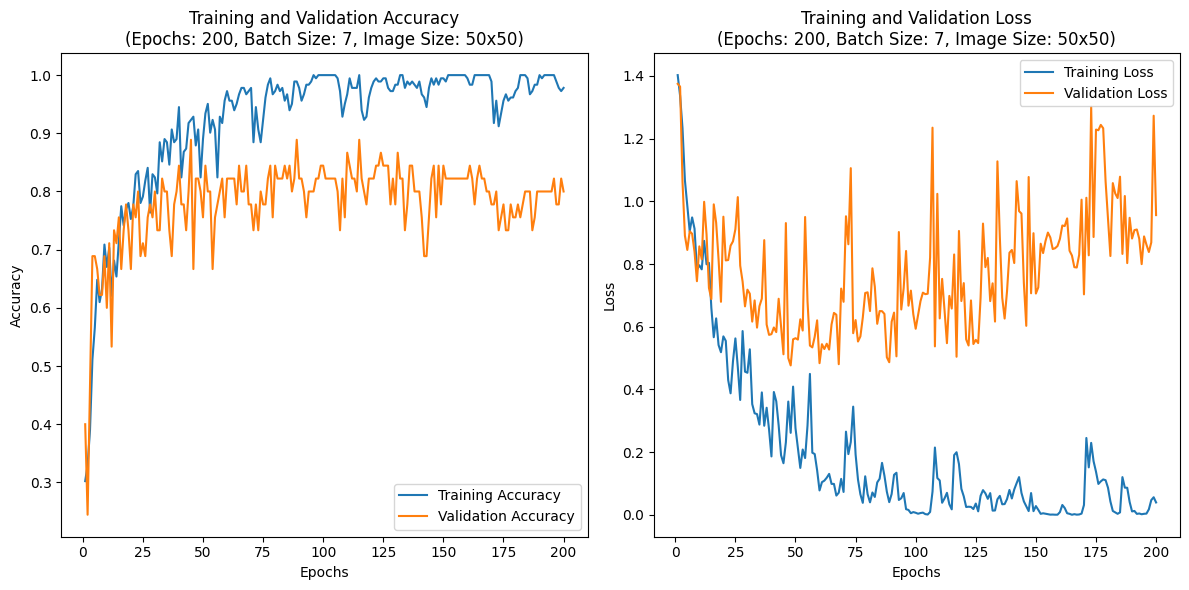

In [7]:
# Evaluate the model on the validation data
val_loss, val_accuracy = model.evaluate(val_data)
print("Validation Loss:", val_loss)
print("Validation Accuracy:", val_accuracy)

# Get training history
train_loss = history.history['loss']
train_accuracy = history.history['accuracy']
val_loss = history.history['val_loss']
val_accuracy = history.history['val_accuracy']

# Create line plots
epochs = range(1, len(train_loss) + 1)

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_accuracy, label='Training Accuracy')
plt.plot(epochs, val_accuracy, label='Validation Accuracy')
plt.title(f'Training and Validation Accuracy\n(Epochs: {epoch_size}, Batch Size: {batch_size}, Image Size: {image_size[0]}x{image_size[1]})')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, train_loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.title(f'Training and Validation Loss\n(Epochs: {epoch_size}, Batch Size: {batch_size}, Image Size: {image_size[0]}x{image_size[1]})')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [8]:
# Save the model after the cross-validation
model.save('/Users/linn/Desktop/neuefische/Hydroponics/models/Modelv2_new.h5')
model.save('/Users/linn/Desktop/neuefische/Hydroponics/models/Modelv2_new.tf')

/Users/linn/Desktop/neuefische/Hydroponics/.venv/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /Users/linn/Desktop/neuefische/Hydroponics/models/Modelv2_new.tf/assets


INFO:tensorflow:Assets written to: /Users/linn/Desktop/neuefische/Hydroponics/models/Modelv2_new.tf/assets


__Optional:__
Reload the saved model so that each time we want to use it it does not need to run again.

In [9]:
#set up import
from tensorflow.keras.models import model_from_json

In [3]:
# load json and create model
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("model_weights.h5")
print("Loaded model from disk")

Loaded model from disk


The reloaded model needs to be compiled again.

In [10]:
# Compile the model
loaded_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

__GUI Gradio__

For visualization

In the following the gradio GUI is set up. It can be used by the link created below.

In [ ]:
# in case gradio is not installed yet
#%pip install gradio

In [14]:
#importing gradio
import gradio as gr

/Users/linn/Desktop/neuefische/Hydroponics/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


The following function takes the input image and 
1) reshapes it according to the model input
2) calls the model to predict and stores the predictions
3) returns the predictions for all the classes

In [19]:
# function to predict with the model
def predict_input_image(img):
  img_4d=img.reshape(-1,50,50,3)
  prediction=loaded_model.predict(img_4d)[0]
  return {class_names[i]: float(prediction[i]) for i in range(4)}

If the model did not run yet and was just loaded, the next code cell needs to be run to create the train data in order to get the class names from it later!

In [ ]:
# # Load and preprocess the data for training set
# data_directory= "Your train data path"

# train_data = tf.keras.preprocessing.image_dataset_from_directory(
#     data_directory,
#     batch_size=batch_size,
#     image_size=image_size,
#     shuffle=True,
#     seed=42,
#     validation_split=0.2,
#     subset="training"
# )

Found 227 files belonging to 4 classes.
Using 182 files for training.


In [12]:
# getting the class names
class_names = train_data.class_names

In [15]:
#resizing the input image
image = gr.inputs.Image(shape=(50,50))

/var/folders/fr/9919jn1n2273x8qrvbr_47080000gn/T/ipykernel_1727/2305234667.py:2: GradioDeprecationWarning: Usage of gradio.inputs is deprecated, and will not be supported in the future, please import your component from gradio.components
  image = gr.inputs.Image(shape=(50,50))
/var/folders/fr/9919jn1n2273x8qrvbr_47080000gn/T/ipykernel_1727/2305234667.py:2: GradioDeprecationWarning: `optional` parameter is deprecated, and it has no effect
  image = gr.inputs.Image(shape=(50,50))


In [16]:
#creating the output labels
label = gr.outputs.Label(num_top_classes=4)

/var/folders/fr/9919jn1n2273x8qrvbr_47080000gn/T/ipykernel_1727/1018824990.py:2: GradioDeprecationWarning: Usage of gradio.outputs is deprecated, and will not be supported in the future, please import your components from gradio.components
  label = gr.outputs.Label(num_top_classes=4)
/var/folders/fr/9919jn1n2273x8qrvbr_47080000gn/T/ipykernel_1727/1018824990.py:2: GradioUnusedKwargWarning: You have unused kwarg parameters in Label, please remove them: {'type': 'auto'}
  label = gr.outputs.Label(num_top_classes=4)


In [17]:
# different layout settings, please see the docs for more: https://www.gradio.app/docs/interface

title = "SmartSense AgroTech Detection System"
description = "Please upload an image of a lettuce plant and let the model detect which probabilites it has to be healthy or defficient in nitrogen, potassium or phosphorus!"
# a more detailed description of the interface can be achieved by article=
theme = gr.themes.Default(primary_hue= "green", secondary_hue= "stone")


In [20]:
# creating the interface, GUI can be accessed by link posted
gr.Interface(fn=predict_input_image, inputs=image, title=title, description= description, theme=theme,  outputs=label,interpretation='default').launch(debug='True')

Running on local URL:  http://127.0.0.1:7860

To create a public link, set `share=True` in `launch()`.


1/1 [==============================] - 0s 124ms/step
Keyboard interruption in main thread... closing server.
